## Compare IC/ICIR of time-series betas and firm characteristics

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats.mstats import spearmanr

In [2]:
df_FF5 = pd.read_csv('df_FF5.csv')

In [3]:
df_FF5.Dates = df_FF5.Dates.apply(lambda x:x[:10])

In [4]:
df_FF5.set_index('Dates',inplace=True)

In [5]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])

In [6]:
# df_SR = df_SR.replace(0,np.nan)

In [7]:
df_Ex_SR = df_SR-df_RF.values

In [8]:
df_Ex_SR = df_Ex_SR.loc[df_FF5.index,:]

In [9]:
df_OP = pd.read_csv('df_std_OP.csv')

df_INV = pd.read_csv('df_std_INV.csv')

df_OP.Dates = df_OP.Dates.apply(lambda x:x[:10])

df_OP.set_index('Dates',inplace=True)

df_INV.Dates = df_INV.Dates.apply(lambda x:x[:10])

df_INV.set_index('Dates',inplace=True)

In [10]:
df_ln_Size = pd.read_csv('df_ln_Size.csv')

df_PE = pd.read_csv('df_std_PE.csv')

df_ln_Size.Dates = df_ln_Size.Dates.apply(lambda x:x[:10])

df_ln_Size.set_index('Dates',inplace=True)

df_PE.Dates = df_PE.Dates.apply(lambda x:x[:10])

df_PE.set_index('Dates',inplace=True)

In [11]:
df_ln_Size = df_ln_Size.loc[df_Ex_SR.index,:]

In [12]:
df_PE = df_PE.loc[df_Ex_SR.index,:]

In [13]:
df_OP = df_OP.loc[df_Ex_SR.index,:]

In [14]:
df_INV = df_INV.loc[df_Ex_SR.index,:]

In [15]:
len(df_ln_Size)==len(df_PE)==len(df_Ex_SR)==len(df_OP)==len(df_INV)

True

In [16]:
## Firm characteristics are lagged for 1 month, to show its predicting ability towards stock returns 
Gap = 21

n = 3
holding = 21
rollingW = holding * n *12
lens = len(df_FF5)
periods = int((lens - rollingW) / holding) - 1

In [17]:
ols_model = LinearRegression()

In [18]:
all_betas = []
# i is time
for i in tqdm(range(periods)):

    df_FF5_tmp = df_FF5.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    # j is stock
    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'SMB',2:'HML',3:'RMW',4:'CMA',5:'stock'}).set_index('stock')
    
    all_betas.append(df_betas)


100%|██████████| 189/189 [02:11<00:00,  1.44it/s]


In [19]:
IC_Series = pd.DataFrame()
k_index = []

df_Ex_SR_tmp_T = df_Ex_SR.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE.iloc[rollingW:rollingW+periods*holding,:].T
df_OP_tmp_T = df_OP.iloc[rollingW:rollingW+periods*holding,:].T
df_INV_tmp_T = df_INV.iloc[rollingW:rollingW+periods*holding,:].T

index_times = list(df_Ex_SR_tmp_T.columns)
 
for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):
    IC = []

    i = int(index_times.index(k) / holding)

    df_index = (((((all_betas[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                    intersection(df_PE_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                    intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index)).\
                    intersection(df_OP_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_INV_tmp_T.loc[:,k].dropna().index))

    df_TS_CS = pd.concat([all_betas[i].loc[df_index,:].astype(np.float64), \
                                         df_ln_Size_tmp_T.loc[df_index,k],\
                                         df_PE_tmp_T.loc[df_index,k], df_OP_tmp_T.loc[df_index,k],\
                                         df_INV_tmp_T.loc[df_index,k]],axis = 1)

    if len(df_index) != 0:
        for j in range(len(df_TS_CS.columns)):
            ic = list(spearmanr(df_TS_CS.iloc[:,j].values,df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]]))[0]
            IC.append(ic)
        k_index.append(k)
    IC_Series = pd.concat([IC_Series, pd.DataFrame(IC)],axis=1)
    

100%|██████████| 3948/3948 [00:59<00:00, 65.80it/s]


In [20]:
spearmanr(df_TS_CS.iloc[:,j].values,df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]])

SpearmanrResult(correlation=-0.010453829710887978, pvalue=0.8191175607129701)

In [21]:
IC_Series_tmp = IC_Series.T.set_index([pd.Index(pd.Series(range(0,len(IC_Series.T))))])
IC_Series_tmp = pd.concat([IC_Series_tmp, pd.DataFrame(k_index)], axis = 1)
IC_Series_tmp.columns = ['MKT','SMB','HML','RMW','CMA','Size','PE','OP','INV','Dates']
IC_Series_tmp = IC_Series_tmp.set_index('Dates')
IC_Series_tmp

,MKT,SMB,HML,RMW,CMA,Size,PE,OP,INV
Dates,,,,,,,,,
2003-11-13,-0.073304,-0.021442,-0.025979,-0.138981,0.009031,-0.051980,0.026301,0.156812,-0.119889
2003-11-14,0.155177,0.027783,-0.000784,-0.083321,-0.006918,0.153099,-0.128262,0.129535,-0.082176
2003-11-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-11-18,0.001761,0.061104,0.050549,-0.138725,0.031916,0.177612,-0.140680,-0.015601,0.058049
2003-11-19,0.194306,-0.064628,0.028069,-0.089857,-0.068786,0.150875,-0.198449,-0.050281,-0.074926
...,...,...,...,...,...,...,...,...,...
2018-12-25,0.003094,0.090399,-0.011641,-0.035164,0.022071,0.056824,-0.019545,-0.067481,0.002177
2018-12-26,-0.115475,-0.017834,-0.034167,0.103246,0.011970,-0.058215,0.087360,0.057237,-0.054356
2018-12-27,0.165100,-0.070401,-0.079854,0.002296,-0.052085,0.122925,-0.025588,-0.049471,-0.035374


In [22]:
IC_Series = IC_Series_tmp
IC_Series

,MKT,SMB,HML,RMW,CMA,Size,PE,OP,INV
Dates,,,,,,,,,
2003-11-13,-0.073304,-0.021442,-0.025979,-0.138981,0.009031,-0.051980,0.026301,0.156812,-0.119889
2003-11-14,0.155177,0.027783,-0.000784,-0.083321,-0.006918,0.153099,-0.128262,0.129535,-0.082176
2003-11-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-11-18,0.001761,0.061104,0.050549,-0.138725,0.031916,0.177612,-0.140680,-0.015601,0.058049
2003-11-19,0.194306,-0.064628,0.028069,-0.089857,-0.068786,0.150875,-0.198449,-0.050281,-0.074926
...,...,...,...,...,...,...,...,...,...
2018-12-25,0.003094,0.090399,-0.011641,-0.035164,0.022071,0.056824,-0.019545,-0.067481,0.002177
2018-12-26,-0.115475,-0.017834,-0.034167,0.103246,0.011970,-0.058215,0.087360,0.057237,-0.054356
2018-12-27,0.165100,-0.070401,-0.079854,0.002296,-0.052085,0.122925,-0.025588,-0.049471,-0.035374


In [23]:
# Annualized the mean of IC_Series
all_ICs = IC_Series.apply(lambda x: x.mean()*np.sqrt(252), axis = 0) 
all_ICs

MKT    -0.033421
SMB    -0.002602
HML    -0.024458
RMW    -0.017979
CMA    -0.004735
Size    0.076508
PE     -0.125319
OP      0.094027
INV     0.013411
dtype: float64

In [24]:
# Annualized ICIR
all_ICIRs = IC_Series.apply(lambda x: x.mean()/x.std()*np.sqrt(252), axis = 0) 
all_ICIRs

MKT    -0.185419
SMB    -0.037281
HML    -0.358329
RMW    -0.271038
CMA    -0.066204
Size    0.451420
PE     -1.734149
OP      1.320473
INV     0.211697
dtype: float64

,IC,ICIR
MKT,-0.033421,-0.185419


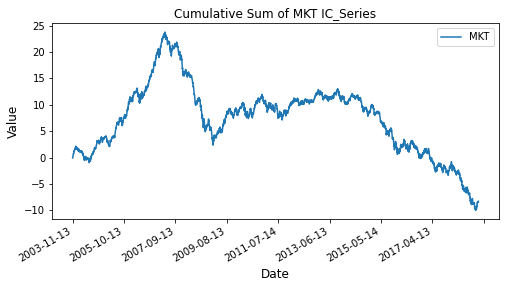

In [25]:
## Plot Cumsum IC_Series of MKT
ax = IC_Series[['MKT']].cumsum().plot(title = 'Cumulative Sum of MKT IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
pd.concat([all_ICs[["MKT"]],all_ICIRs[["MKT"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

,IC,ICIR
SMB,-0.002602,-0.037281
Size,0.076508,0.451420


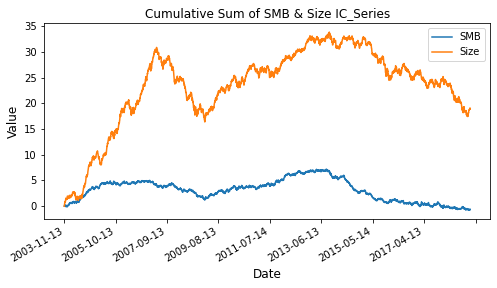

In [26]:
## Plot Cumsum IC_Series of SMB & Size
ax = IC_Series[["SMB","Size"]].cumsum().plot(title = 'Cumulative Sum of SMB & Size IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
pd.concat([all_ICs[["SMB","Size"]],all_ICIRs[["SMB","Size"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

,IC,ICIR
HML,-0.024458,-0.358329
PE,-0.125319,-1.734149


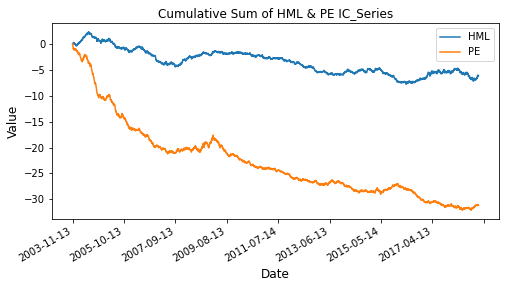

In [27]:
## Plot Cumsum IC_Series of HML & PE
ax = IC_Series[["HML","PE"]].cumsum().plot(title = 'Cumulative Sum of HML & PE IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
pd.concat([all_ICs[["HML","PE"]],all_ICIRs[["HML","PE"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

,IC,ICIR
RMW,-0.017979,-0.271038
OP,0.094027,1.320473


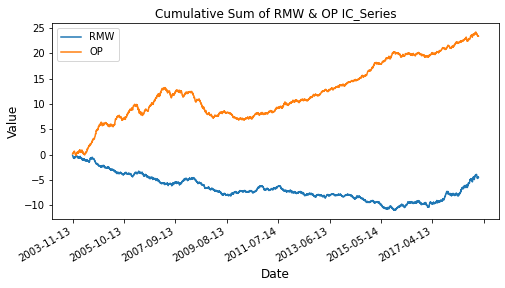

In [28]:
## Plot Cumsum IC_Series of RMW & OP
ax = IC_Series[["RMW","OP"]].cumsum().plot(title = 'Cumulative Sum of RMW & OP IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
pd.concat([all_ICs[["RMW","OP"]],all_ICIRs[["RMW","OP"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

,IC,ICIR
CMA,-0.004735,-0.066204
INV,0.013411,0.211697


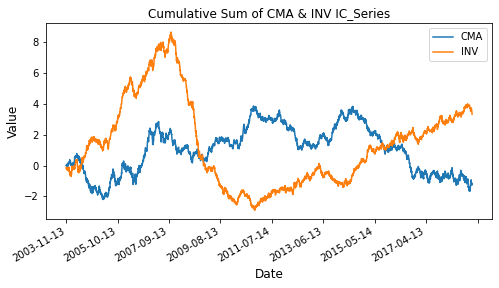

In [29]:
## Plot Cumsum IC_Series of CMA & INV
ax = IC_Series[["CMA","INV"]].cumsum().plot(title = 'Cumulative Sum of CMA & INV IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
pd.concat([all_ICs[["CMA","INV"]],all_ICIRs[["CMA","INV"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

In [30]:
pd.concat([all_ICs[["MKT"]],all_ICIRs[["MKT"]]],axis=1).rename(columns={0:'IC',1:'ICIR'}).\
append(pd.concat([all_ICs[["SMB","Size"]],all_ICIRs[["SMB","Size"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})).\
append(pd.concat([all_ICs[["HML","PE"]],all_ICIRs[["HML","PE"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})).\
append(pd.concat([all_ICs[["RMW","OP"]],all_ICIRs[["RMW","OP"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})).\
append(pd.concat([all_ICs[["CMA","INV"]],all_ICIRs[["CMA","INV"]]],axis=1).rename(columns={0:'IC',1:'ICIR'}))

,IC,ICIR
MKT,-0.033421,-0.185419
SMB,-0.002602,-0.037281
Size,0.076508,0.451420
HML,-0.024458,-0.358329
PE,-0.125319,-1.734149
RMW,-0.017979,-0.271038
OP,0.094027,1.320473
CMA,-0.004735,-0.066204
INV,0.013411,0.211697
